 <center><h1 style="font-size:4rem;color:#008080;">US Stock Market Time Series Analysis</h1></center>
 <center><h6 style="font-size:2rem;color:#008080;">Data as of March 31, 2024</h6></center>

The project encompasses three key components:

1. Forecasting the future value of the US corporate profit margin after tax.
2. Use the forecasted value to analyse the relationship between the market index and selected major economic indicators.
3. Develop a model aimed at evaluate market sentiment dynamics.

This analysis aims to shed light on how the market index interacts with specific economic indicators, blending statistical analysis with fundamental economic principles.

<center><h1 style="font-size:2.5rem;color:grey;">
Dependencies</h1></center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from itertools import product
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm
from tabulate import tabulate
from tqdm import tqdm_notebook
from pmdarima import auto_arima
import warnings

warnings.filterwarnings('ignore')


In [2]:
current_directory = os.getcwd()
file_path = os.path.join(current_directory, 'cleaned_data.csv')
df = pd.read_csv(file_path, index_col = 0, parse_dates = True)
df.index.freq = 'QS-OCT'

 <center><h1 style="font-size:3rem;color:purple;">Profit Margin Time Series Prediction</h1></center>

The aim of this section is to employ various statistical models, including ARIMA, VAR, linear regression, and random forest, to forecast the profit margin value. Then identify the most appropriate model for generating forecast values to be utilised in the subsequent market analysis.

### Set up


In [3]:
df.tail(5)

,market_index,gdp,interest_rate,cpi,profit_margin
date,,,,,
2023-01-01,199.225806,26813.601,0.045167,301.744,0.0869
2023-04-01,208.604032,27063.012,0.049900,304.003,0.0961
2023-07-01,222.245714,27610.128,0.052600,307.288,0.0977
2023-10-01,222.756984,27956.998,0.053300,308.742,0.1003
2024-01-01,250.156557,28284.498,0.053300,312.230,NaN



The table presented above indicates that the "profit_margin" field is missing the most recent value. Delays in reporting corporate profit margin after tax data often occur due to variances in companies' fiscal reporting periods. However, it is noteworthy that profit margins typically exhibit relatively stable trends over time, rendering them reasonably predictable.

In [4]:
n_forecast = 1 # number of period(s) forecasting ahead.
n_test = 4 # number of testing periods.
df_pm = df[df['profit_margin'].notna()][['profit_margin']]
df_pm

,profit_margin
date,
1971-01-01,0.0548
1971-04-01,0.0549
1971-07-01,0.0568
1971-10-01,0.0595
1972-01-01,0.0604
...,...
2022-10-01,0.0937
2023-01-01,0.0869
2023-04-01,0.0961


Text(0.5, 0, 'Date')

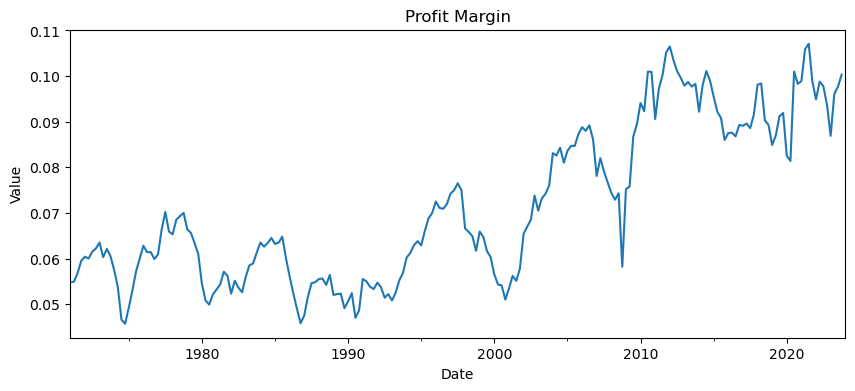

In [5]:
df['profit_margin'].plot(figsize=(10,4))
plt.title('Profit Margin')
plt.ylabel('Value')
plt.xlabel('Date')

#### White noise


Upon visual inspection, it is apparent that there is a trend overtime in the dataset. This suggests that the data does not adhere to the characteristics of white noise. Consequently, potential for making predictions using time series analysis techniques.

<center><h1 style="font-size:2.5rem;color:green;">
ARIMA</h1></center>

# ARMA or ARIMA

### Augmented Dickey-Fuller test

In [6]:
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(df_pm)

1. ADF :  -1.3788121097506558
2. P-Value :  0.5923906598883197
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 211
5. Critical Values :
	 1% :  -3.46172743446274
	 5% :  -2.8753374677799957
	 10% :  -2.574124089081557



The p-value derived from the Augmented Dickey-Fuller (ADF) test surpasses the commonly accepted significance threshold of 5%. As a result, the null hypothesis, suggesting non-stationarity in the profit margin series, cannot be dismissed. Therefore, it is advisable to employ the Autoregressive Integrated Moving Average (ARIMA) model rather than the Autoregressive Moving Average (ARMA) model for conducting comprehensive time series analysis.

# Order selection

In [7]:
stepwise_fit = auto_arima(df_pm, trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1727.323, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1735.323, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1733.467, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1733.478, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1736.686, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1731.339, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.266 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 869.343
Date:                Tue, 07 May 2024   AIC                          -1736.686
Time:                        21:40:20   BIC                          -1733.334
Sample:                    01-01-1971   HQIC                         -1735.331
                         - 10-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.541e-05   8.03e-07     19.184      0.000    1.38e-05     1.7e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               216.00
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               4.29   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ACF & PACF plot

Text(0.5, 1.0, 'Autorcorrelation for Profit Margin')

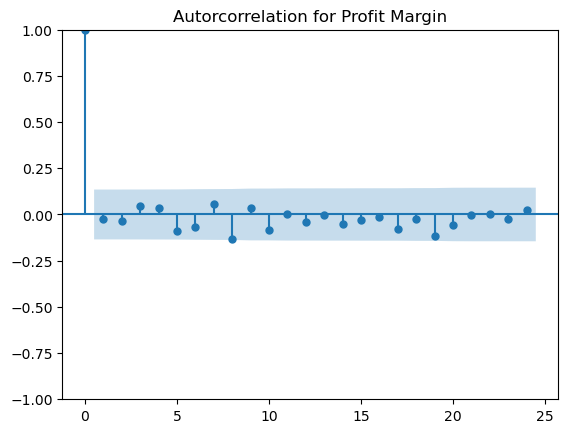

In [8]:
accf_arima = plot_acf(df_pm.diff()[1:])
plt.title('Autorcorrelation for Profit Margin')


Text(0.5, 1.0, 'Partial Autorcorrelation for Profit Margin')

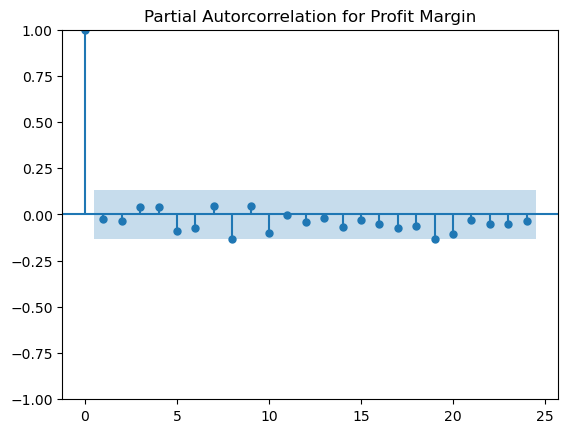

In [9]:
pacf_arima = plot_pacf(df_pm.diff()[1:])
plt.title('Partial Autorcorrelation for Profit Margin')

The ARIMA(0,1,0) model was selected based on its minimal Akaike Information Criterion (AIC), indicating superior fit to the data. Additionally, examination of both the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots revealed the absence of significant lags, further affirming the appropriateness of the selected model.

### Model building

In [10]:
train_arima = df_pm.iloc[:-n_test]
test_arima = df_pm.iloc[-n_test:]

In [11]:
arima_order =(0,1,0)
arimamodel = ARIMA(train_arima,order=arima_order)
arimamodel = arimamodel.fit()

<center><h1 style="font-size:2rem;color:blue">
In-sample prediction</h1></center>

In [12]:
start = len(train_arima)
end = len(train_arima) + len(test_arima) - 1 

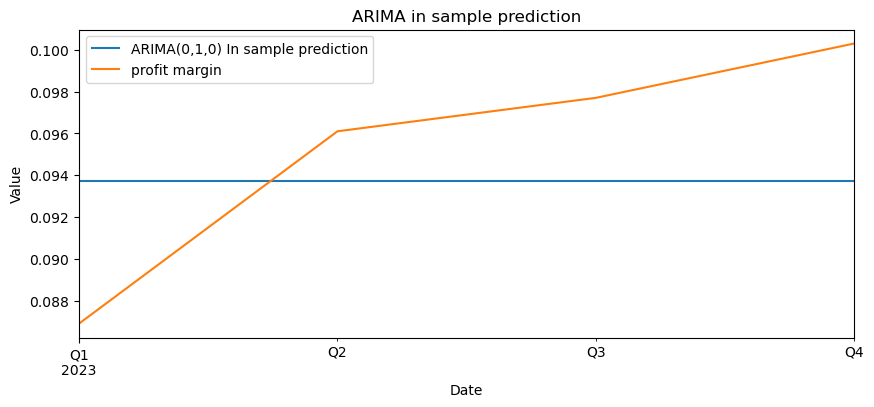

In [13]:
pred_arima = arimamodel.predict(start = start, end = end, typ = 'levels').rename('ARIMA(0,1,0) In sample prediction')
pred_arima.plot(legend = True, figsize = (10,4))
test_arima['profit_margin'].plot(legend = True, figsize = (10,4))
plt.legend(labels=['ARIMA(0,1,0) In sample prediction', 'profit margin'])
plt.ylabel('Value')
plt.xlabel('Date')
plt.title('ARIMA in sample prediction')
plt.show()

By definition, ARIMA (0,1,0) model means that the series has been differenced once to make it stationary, and it does not include any autoregressive or moving average terms. Intuitively, this model could be used for forecasting a time series that exhibits a consistent trend, but no seasonality or autocorrelation.

 <center><h1 style="font-size:2rem;color:#008080;">MAPE</h1></center>

In [14]:
mape_arima = round(mean_absolute_percentage_error(test_arima['profit_margin'], pred_arima) * 100, 2)
print('Mean Absolute Percentage Error under ARIMA(0,1,0) is : {} %'.format(mape_arima))

Mean Absolute Percentage Error under ARIMA(0,1,0) is : 5.25 %


<center><h1 style="font-size:2rem;color:blue">
Forecast</h1></center>

In [15]:
ts1 = ARIMA(df_pm, order=arima_order)
ts1_fit = ts1.fit()
arima_forecast = ts1_fit.forecast(steps=n_forecast)[0]
print("arima forecast:", arima_forecast)


arima forecast: 0.1003


<center><h1 style="font-size:2.5rem;color:green;">
 VAR</h1></center>


Adding the interest rate to the VAR model alongside corporate profit margins after tax can improve forecasting by capturing how changes in interest rates affect borrowing costs, consumer spending, and investment decisions, thereby influencing corporate profitability. This inclusion provides insights into the dynamic relationship between interest rate movements and corporate earnings, enhancing the model's ability to anticipate changes in profit margins.

In [16]:
df_pm_ir = df[df['profit_margin'].notna()][['profit_margin', 'interest_rate']]


In [17]:
df_pm_ir

,profit_margin,interest_rate
date,,
1971-01-01,0.0548,0.038567
1971-04-01,0.0549,0.045667
1971-07-01,0.0568,0.054767
1971-10-01,0.0595,0.047500
1972-01-01,0.0604,0.035467
...,...,...
2022-10-01,0.0937,0.036533
2023-01-01,0.0869,0.045167
2023-04-01,0.0961,0.049900


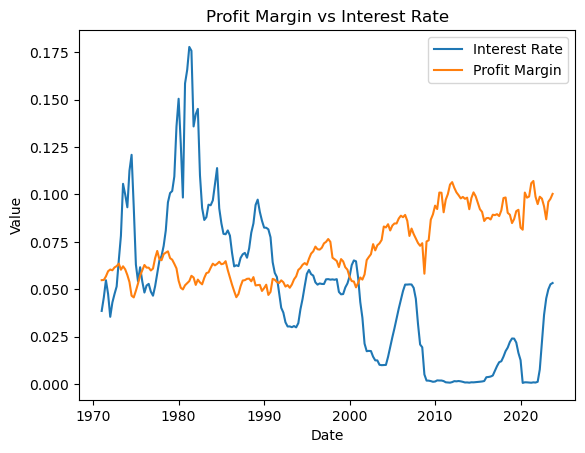

In [18]:
plt.plot(df_pm_ir.index, df_pm_ir['interest_rate'], label='Interest Rate')
plt.plot(df_pm_ir.index, df_pm_ir['profit_margin'], label='Profit Margin')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Profit Margin vs Interest Rate')
plt.plotfigsize = (10,4)
plt.legend()
plt.show()

### Augmented Dickey-Fuller test

In [19]:
ad_fuller_result_1 = adfuller(df_pm_ir['profit_margin'].diff()[1:])
print('Profit margin')
print(f'ADF Statisitc:{ad_fuller_result_1[0]}')
print(f'p-value:{ad_fuller_result_1[1]}')
print()
ad_fuller_result_2 = adfuller(df_pm_ir['interest_rate'].diff()[1:])
print('Interest rates')
print(f'ADF Statisitc:{ad_fuller_result_2[0]}')
print(f'p-value:{ad_fuller_result_2[1]}')

Profit margin
ADF Statisitc:-14.793007270916444
p-value:2.1567193537527807e-27

Interest rates
ADF Statisitc:-6.131977725390502
p-value:8.359467380348921e-08


There is strong evidence that both the profit margin and interst rate are stationary after first differencing.

## Order Selection


### Granger Causality Test

In [20]:
print('Testing whether interest rate Granger-causes profit margin\n')
granger = grangercausalitytests(df_pm_ir, 15, addconst=True, verbose=True)

Testing whether interest rate Granger-causes profit margin


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.0569 , p=0.0001  , df_denom=208, df_num=1
ssr based chi2 test:   chi2=17.3029 , p=0.0000  , df=1
likelihood ratio test: chi2=16.6300 , p=0.0000  , df=1
parameter F test:         F=17.0569 , p=0.0001  , df_denom=208, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.8155  , p=0.0002  , df_denom=205, df_num=2
ssr based chi2 test:   chi2=18.0611 , p=0.0001  , df=2
likelihood ratio test: chi2=17.3263 , p=0.0002  , df=2
parameter F test:         F=8.8155  , p=0.0002  , df_denom=205, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.8307  , p=0.0008  , df_denom=202, df_num=3
ssr based chi2 test:   chi2=18.0982 , p=0.0004  , df=3
likelihood ratio test: chi2=17.3571 , p=0.0006  , df=3
parameter F test:         F=5.8307  , p=0.0008  , df_denom=202, df_num=3

Granger Causality
number of lags 

Interest rate's first 8 lags are significant at the 5% level in explaining the profit margin's movements.

### Computer Selection

In [21]:
train_var = df_pm_ir[:-n_test]
test_var = df_pm_ir[-n_test:]

In [22]:
varmodel = VAR(train_var.diff()[1:])
sorted_order = varmodel.select_order(maxlags = 10)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -20.45     -20.42*   1.312e-09      -20.44
1       -20.48      -20.38   1.276e-09     -20.44*
2       -20.49      -20.32   1.263e-09      -20.42
3       -20.50      -20.27   1.246e-09      -20.41
4       -20.47      -20.17   1.285e-09      -20.35
5      -20.52*      -20.15  1.226e-09*      -20.37
6       -20.50      -20.07   1.248e-09      -20.33
7       -20.51      -20.01   1.234e-09      -20.31
8       -20.49      -19.92   1.263e-09      -20.26
9       -20.46      -19.83   1.299e-09      -20.21
10      -20.44      -19.74   1.327e-09      -20.16
--------------------------------------------------


The fifth-order VAR model demonstrates the lowest AIC value among the considered models. In line with prioritising model simplicity and efficiency, the decision has been made to select the fifth-order VAR model for further analysis and interpretation.

### Model Building

In [23]:
var_order = (5,0) # fifth-order VAR model.
var_model = VARMAX(train_var, order = var_order, enforce_stationarity = True)
fitted_model = var_model.fit(disp = False)
print(fitted_model.summary())

                                   Statespace Model Results                                   
Dep. Variable:     ['profit_margin', 'interest_rate']   No. Observations:                  208
Model:                                         VAR(5)   Log Likelihood                1563.460
                                          + intercept   AIC                          -3076.921
Date:                                Tue, 07 May 2024   BIC                          -2993.482
Time:                                        21:40:21   HQIC                         -3043.182
Sample:                                    01-01-1971                                         
                                         - 10-01-2022                                         
Covariance Type:                                  opg                                         
Ljung-Box (L1) (Q):             0.00, 0.02   Jarque-Bera (JB):      190.65, 2075.76
Prob(Q):                        0.99, 0.89   Prob(JB):       

<center><h1 style="font-size:2rem;color:blue">
In-sample predictions</h1></center>

In [24]:
predict_var = fitted_model.get_prediction(start = start, end = end)
predictions_var = predict_var.predicted_mean
predictions_var.columns = ['profit_margin_pred','int_pred']
predictions_var = predictions_var.drop('int_pred', axis = 1)

Text(0.5, 0, 'Date')

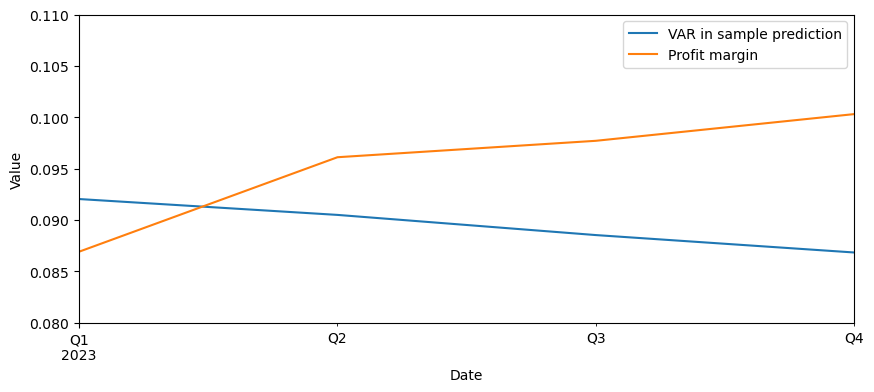

In [25]:
pred_var = pd.concat([test_var, predictions_var], axis = 1)
pred_var[['profit_margin_pred','profit_margin']].plot(figsize = (10,4))
plt.legend(['VAR in sample prediction','Profit margin' ])
plt.ylim(0.08, 0.11)
plt.ylabel('Value')
plt.xlabel('Date')

 <center><h1 style="font-size:2rem;color:#008080;">MAPE</h1></center>

In [26]:
mape_var = round(mean_absolute_percentage_error(test_var['profit_margin'], predictions_var['profit_margin_pred']) * 100, 2)
print('Mean Absolute Percentage Error of Profit Margin under VAR Model is : {} %'.format(mape_var))

Mean Absolute Percentage Error of Profit Margin under VAR Model is : 8.65 %



The Vector Autoregression model (VAR) suggests that an increase in interest rates should lead to a decrease in the corporate profit margin. However, contrary to this expectation, there has been an observed increase in the corporate profit margin. This unexpected outcome may be attributed to recent advancements in generative AI technology.


<center><h1 style="font-size:2rem;color:blue">
Forecast</h1></center>

In [27]:
ts2 = VARMAX(df_pm_ir, order = var_order, enforce_stationarity = True)
ts2_fit = ts2.fit(disp = False)
var_forecast=ts2_fit.forecast(steps=n_forecast)['profit_margin'][0]
print("var forecast:",var_forecast)

var forecast: 0.09784981023669143


<center><h1 style="font-size:2.5rem;color:green;">
Linear Regression & Random Forest</h1></center>

## Model Setups

In [28]:
# creating auto-lagged data
df_pm_ml = df_pm
df_pm_ml['profit_margin-1Q'] = df['profit_margin'].shift(+1)
df_pm_ml['profit_margin-2Q'] = df['profit_margin'].shift(+2)
df_pm_ml['profit_margin-3Q'] = df['profit_margin'].shift(+3)
df_pm_ml = df_pm_ml.dropna()
df_pm_ml

,profit_margin,profit_margin-1Q,profit_margin-2Q,profit_margin-3Q
date,,,,
1971-10-01,0.0595,0.0568,0.0549,0.0548
1972-01-01,0.0604,0.0595,0.0568,0.0549
1972-04-01,0.0600,0.0604,0.0595,0.0568
1972-07-01,0.0615,0.0600,0.0604,0.0595
1972-10-01,0.0622,0.0615,0.0600,0.0604
...,...,...,...,...
2022-10-01,0.0937,0.0978,0.0988,0.0949
2023-01-01,0.0869,0.0937,0.0978,0.0988
2023-04-01,0.0961,0.0869,0.0937,0.0978


In [29]:
lr_ml = LinearRegression()
rf_ml = RandomForestRegressor(n_estimators = 100, max_features = 3, random_state = 1) # The values here can be changed accordingly.

# Concatanating data for in-sample forecasts
x1_ml, x2_ml, x3_ml, y_ml = df_pm_ml['profit_margin-1Q'], df_pm_ml['profit_margin-2Q'], df_pm_ml['profit_margin-3Q'], df_pm_ml['profit_margin']
x1_ml, x2_ml, x3_ml, y_ml = np.array(x1_ml), np.array(x2_ml), np.array(x3_ml), np.array(y_ml)
x1_ml, x2_ml, x3_ml, y_ml = x1_ml.reshape(-1,1), x2_ml.reshape(-1,1), x3_ml.reshape(-1,1), y_ml.reshape(-1,1)
final_x_ml = np.concatenate((x1_ml, x2_ml, x3_ml), axis = 1)
final_x_ml.shape

(209, 3)

In [30]:
# Splitting the data into training and testing groups
x_train_ml, x_test_ml, y_train_ml, y_test_ml = final_x_ml[:-n_test], final_x_ml[-n_test:], y_ml[:-n_test], y_ml[-n_test:]
lr_ml.fit(x_train_ml, y_train_ml)
rf_ml.fit(x_train_ml, y_train_ml)

RandomForestRegressor(max_features=3, random_state=1)

<center><h1 style="font-size:2rem;color:blue">
In-sample predictions</h1></center>

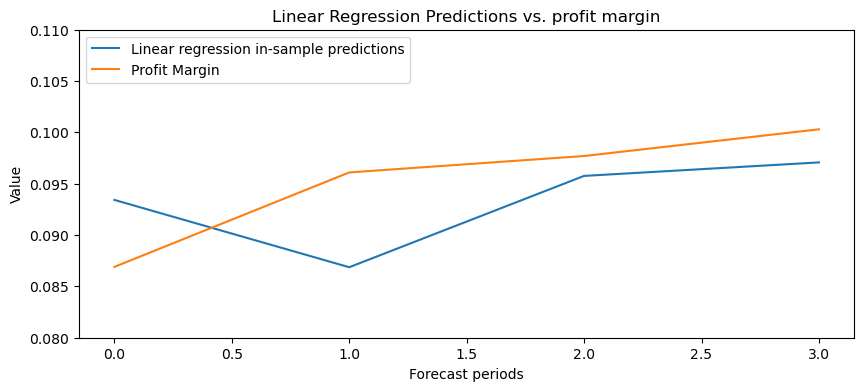

In [31]:
lin_pred_ml = lr_ml.predict(x_test_ml)
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(lin_pred_ml , label = 'Linear regression in-sample predictions')
plt.plot(y_test_ml, label = 'Profit Margin')
plt.legend(loc = "upper left")
plt.ylim(0.08, 0.11)
plt.ylabel('Value')
plt.xlabel('Forecast periods')
plt.title('Linear Regression Predictions vs. profit margin')
plt.show()

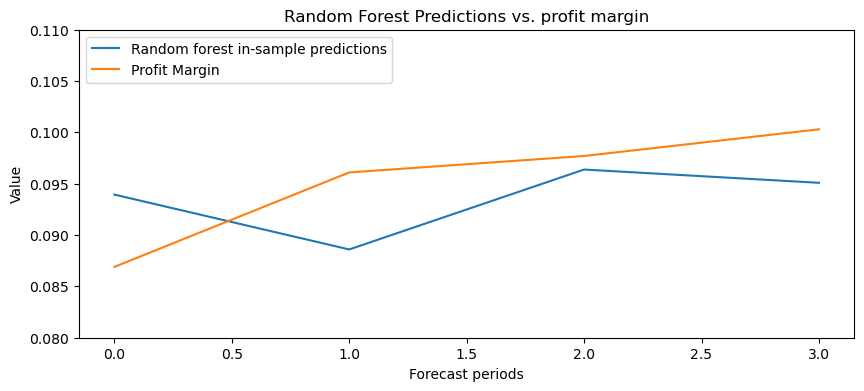

In [32]:
pred_ml = rf_ml.predict(x_test_ml)
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(pred_ml, label = 'Random forest in-sample predictions')
plt.plot(y_test_ml, label = 'Profit Margin')
plt.legend(loc = "upper left")
plt.ylim(0.08, 0.11)
plt.ylabel('Value')
plt.xlabel('Forecast periods')
plt.title('Random Forest Predictions vs. profit margin')
plt.show()

 <center><h1 style="font-size:2rem;color:#008080;">MAPE</h1></center>

In [33]:
mape_lr_ml = round(mean_absolute_percentage_error(y_test_ml, lin_pred_ml) * 100, 2)
print('Mean Absolute Percentage Error under Linear Regression Model is : {} %'.format(mape_lr_ml))
mape_rf_ml = round(mean_absolute_percentage_error(y_test_ml, pred_ml) * 100, 2)
print('Mean Absolute Percentage Error under Random Forest Model is: {} %'.format(mape_rf_ml))

Mean Absolute Percentage Error under Linear Regression Model is : 5.58 %
Mean Absolute Percentage Error under Random Forest Model is: 5.61 %


Both Linear Regression (LR) and Random Forest (RF) models demonstrate sensitivity to fluctuations in profit margin dynamics. However, it's noteworthy that both models may be susceptible to overfitting due to their complexity.

<center><h1 style="font-size:2rem;color:blue">
Forecast</h1></center>

In [34]:
# Predicting one period ahead with linear regression
lr_forecast = lr_ml.predict(final_x_ml[-1].reshape(1, -1))[0][0]
print("Linear Regression Forecast:", lr_forecast)

# Predicting one period ahead with random forest
rf_forecast = rf_ml.predict(final_x_ml[-1].reshape(1, -1))[0]
print("Random Forest Forecast:", rf_forecast)

Linear Regression Forecast: 0.09707552813728464
Random Forest Forecast: 0.09508999999999991


 <center><h3 style="font-size:2rem;color:#FF8C00;"> Profit Margin summary</h3></center>

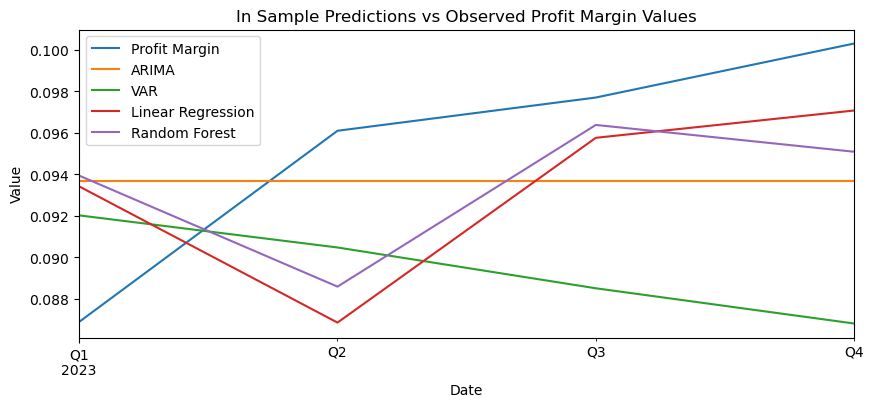

In [35]:
test_arima['profit_margin'].plot(legend = True, label='Profit Margin')
pred_arima.plot(legend = True, figsize = (10,4), label='ARIMA')

pred_var['profit_margin_pred'].plot(label='VAR')

lin_pred_ml = pd.Series(lr_ml.predict(x_test_ml).flatten(), index=df_pm_ml.index[-n_test:])
lin_pred_ml.plot(label='Linear Regression')

rf_pred_ml = pd.Series(rf_ml.predict(x_test_ml).flatten(), index=df_pm_ml.index[-n_test:])
rf_pred_ml.plot(label='Random Forest')

plt.legend()
plt.ylabel('Value')
plt.xlabel('Date')
plt.title('In Sample Predictions vs Observed Profit Margin Values')
plt.show()

In [36]:
table_data = [
    ["Model", "Mean Absolute Percentage Error (%)", "Forecast"],
    ["ARIMA(0,1,0)", mape_arima, round(arima_forecast, 4)],
    ["VAR Model", mape_var, round(var_forecast, 4)],
    ["Linear Regression", mape_lr_ml, round(lr_forecast, 4)],
    ["Random Forest", mape_rf_ml, round(rf_forecast, 4)]
]

print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

+-------------------+--------------------------------------+------------+
| Model             |   Mean Absolute Percentage Error (%) |   Forecast |
+===================+======================================+============+
| ARIMA(0,1,0)      |                                 5.25 |     0.1003 |
+-------------------+--------------------------------------+------------+
| VAR Model         |                                 8.65 |     0.0978 |
+-------------------+--------------------------------------+------------+
| Linear Regression |                                 5.58 |     0.0971 |
+-------------------+--------------------------------------+------------+
| Random Forest     |                                 5.61 |     0.0951 |
+-------------------+--------------------------------------+------------+


After careful analysis, the decision has been made to adopt the ARIMA model for profit margin forecasting, owing to its demonstrated superiority in minimising Mean Absolute Percentage Error (MAPE) compared to alternative models, thereby prioritising forecasting accuracy. 

The simplicity and straightforward implementation of the ARIMA model further contribute to its favourable selection for forecasting needs. Notably, the ARIMA(0,1,0) specification implies that the profit margin behaves akin to a random walk with a drift component, indicating a linear trend in the profit margin, which aligns well with established economic principles.

In [37]:
df_updated = df.copy()
df_updated.loc[df.index[-1], 'profit_margin'] = arima_forecast

 <center><h1 style="font-size:3rem;color:purple;">Market Index Analysis</h1></center>

In [38]:
df_updated

,market_index,gdp,interest_rate,cpi,profit_margin
date,,,,,
1971-01-01,1.080000,1135.156,0.038567,40.000,0.0548
1971-04-01,1.136667,1156.271,0.045667,40.500,0.0549
1971-07-01,1.113333,1177.675,0.054767,40.800,0.0568
1971-10-01,1.113333,1190.297,0.047500,41.100,0.0595
1972-01-01,1.240000,1230.609,0.035467,41.400,0.0604
...,...,...,...,...,...
2023-01-01,199.225806,26813.601,0.045167,301.744,0.0869
2023-04-01,208.604032,27063.012,0.049900,304.003,0.0961
2023-07-01,222.245714,27610.128,0.052600,307.288,0.0977


These selected metrics are significant economic indicators that have the potential to influence the overall stock market:

1. "market_index" denotes the Wilshire5000 index, a comprehensive measure of the total U.S. stock market's performance.
2. "gdp" signifies the nominal gross domestic product (GDP) of the United States, a key indicator of the nation's economic health and productivity.
3. "interest_rate" represents the US federal funds rate, expressed as a percentage, which serves as a pivotal benchmark for short-term interest rates and business cost of borrowing.
4. "cpi" stands for the Consumer Price Index (CPI) for All Urban Consumers: All Items in U.S. City Average, a widely used measure of inflation that reflects changes in the cost of living over time.
5. "profit_margin" indicates the US corporate profit after tax rate, expressed as a percentage, offering insights into how technology advancements have increased business's profitability.

The "date" column represents the date beginning in that quarter. For example, "2024-01-01" indicates the date range from January 1, 2024, to March 31, 2024.

Text(0.5, 0, 'Date')

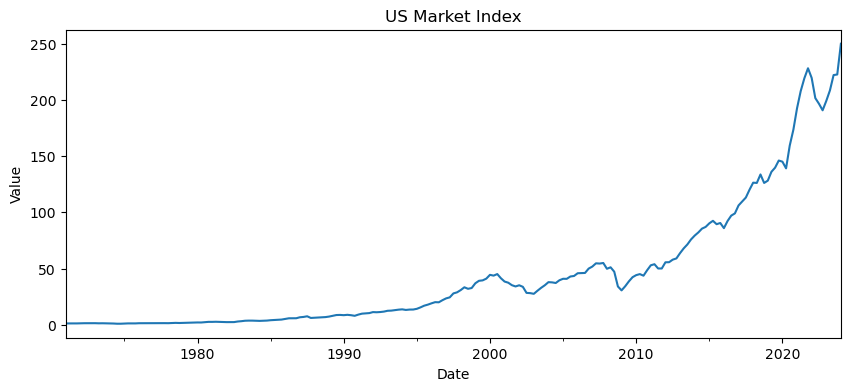

In [39]:
df_updated['market_index'].plot(figsize=(10,4))
plt.ylabel('Value')
plt.title('US Market Index')
plt.xlabel('Date')

<center><h1 style="font-size:2.5rem;color:green;">
 Market Index controlling for Inflationary</h1></center>

The objective of this study is to investigate the impact of inflation on the market index through the utilisation of a simple regression model. Specifically, the aim is to discern how the market index would fluctuate in the absence of inflationary effects, as represented by the Consumer Price Index (CPI). By controlling for inflation, the study seeks to isolate and analyse the underlying dynamics of the market index, providing valuable insights into its behavior independent of inflationary pressures.

### Regression

In [40]:
x_var, y_var = df_updated['cpi'], df_updated['market_index']
x_var_1 = sm.add_constant(x_var)
rg1 = sm.OLS(y_var, x_var_1).fit() # ordinary least square method.
print(rg1.summary())

                            OLS Regression Results                            
Dep. Variable:           market_index   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     532.3
Date:                Tue, 07 May 2024   Prob (F-statistic):           1.30e-59
Time:                        21:40:23   Log-Likelihood:                -1029.3
No. Observations:                 213   AIC:                             2063.
Df Residuals:                     211   BIC:                             2069.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -62.9649      5.102    -12.341      0.0

1. The simple regression analysis conducted indicates a robust relationship between the market index and the Consumer Price Index (CPI). With an R-squared value of 0.716, approximately 71.6% of the variation in the market index can be explained by changes in CPI, suggesting a strong predictive power of CPI on market performance. 
2. The extremely low probability associated with the F-statistic (1.30e-59) further underscores the significance of the model, implying that CPI is indeed a significant predictor of the market index. Specifically, the coefficient of 0.6675 for CPI suggests that for every one-unit increase in CPI, the market index is expected to increase by 0.6675 units, holding other factors constant. Moreover, the p-value of 0.000 indicates that this relationship is highly unlikely to be due to chance alone. 

From an economic standpoint, it aligns with conventional wisdom that changes in the Consumer Price Index, a measure of inflation, could impact market dynamics. For instance, as CPI rises, indicating higher inflation, increases investor expectations, which can influence stock market performance. Therefore, the statistical results not only demonstrate a strong empirical relationship but also make economic sense by reflecting the interplay between CPI and market movements.

### Graphs

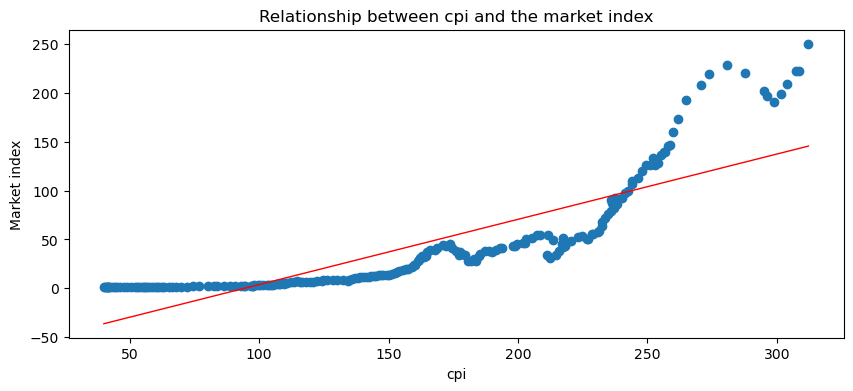

In [41]:
x_axis, y_axis = np.array(x_var_1), np.array(y_var).reshape(-1,1)
plt.figure(figsize=(10,4))
plt.scatter(x_axis[:, 1], y_axis)
plt.plot(x_axis[:, 1], rg1.predict(x_axis), color = 'r', linewidth = 1)
plt.xlabel('cpi')
plt.ylabel('Market index')
plt.title('Relationship between cpi and the market index')
plt.show()

Text(0.5, 1.0, 'Simple Linear Regression Model vs Market Index')

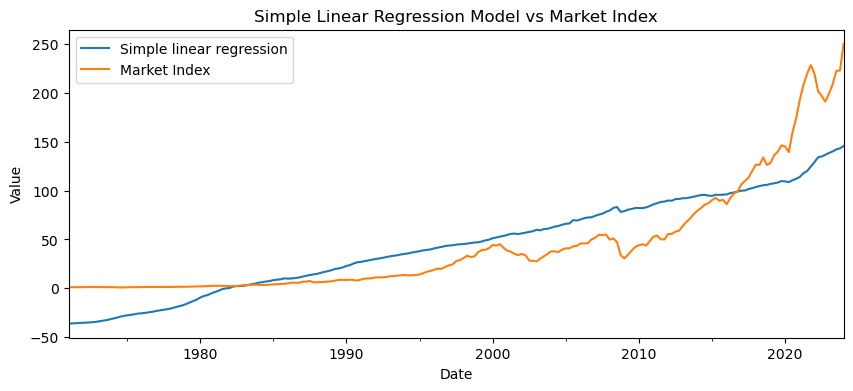

In [42]:
plt.figure(figsize=(10,4))
pred_simple = rg1.predict(x_var_1)
pred_simple.plot(legend = True)
df['market_index'].plot(legend = True)
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(labels=['Simple linear regression', 'Market Index'])
plt.title('Simple Linear Regression Model vs Market Index')


The analysis presented above demonstrates that upon incorporating the Consumer Price Index (CPI) as a control variable in the simple regression model, the model exhibits notable improvements in stability and predictability. Specifically, the dispersion between the highest and lowest values diminishes considerably compared to the raw market index data. This suggests that by controlling for CPI, the model achieves a more refined representation of market dynamics, potentially enhancing its reliability for forecasting and decision-making purposes.

<center><h1 style="font-size:2.5rem;color:green;">
Market Framework


The objective is to examine the relationship between the market index and key economic indicators, including GDP, interest rates, CPI, and profit margins, by utilising a multiple regression model.

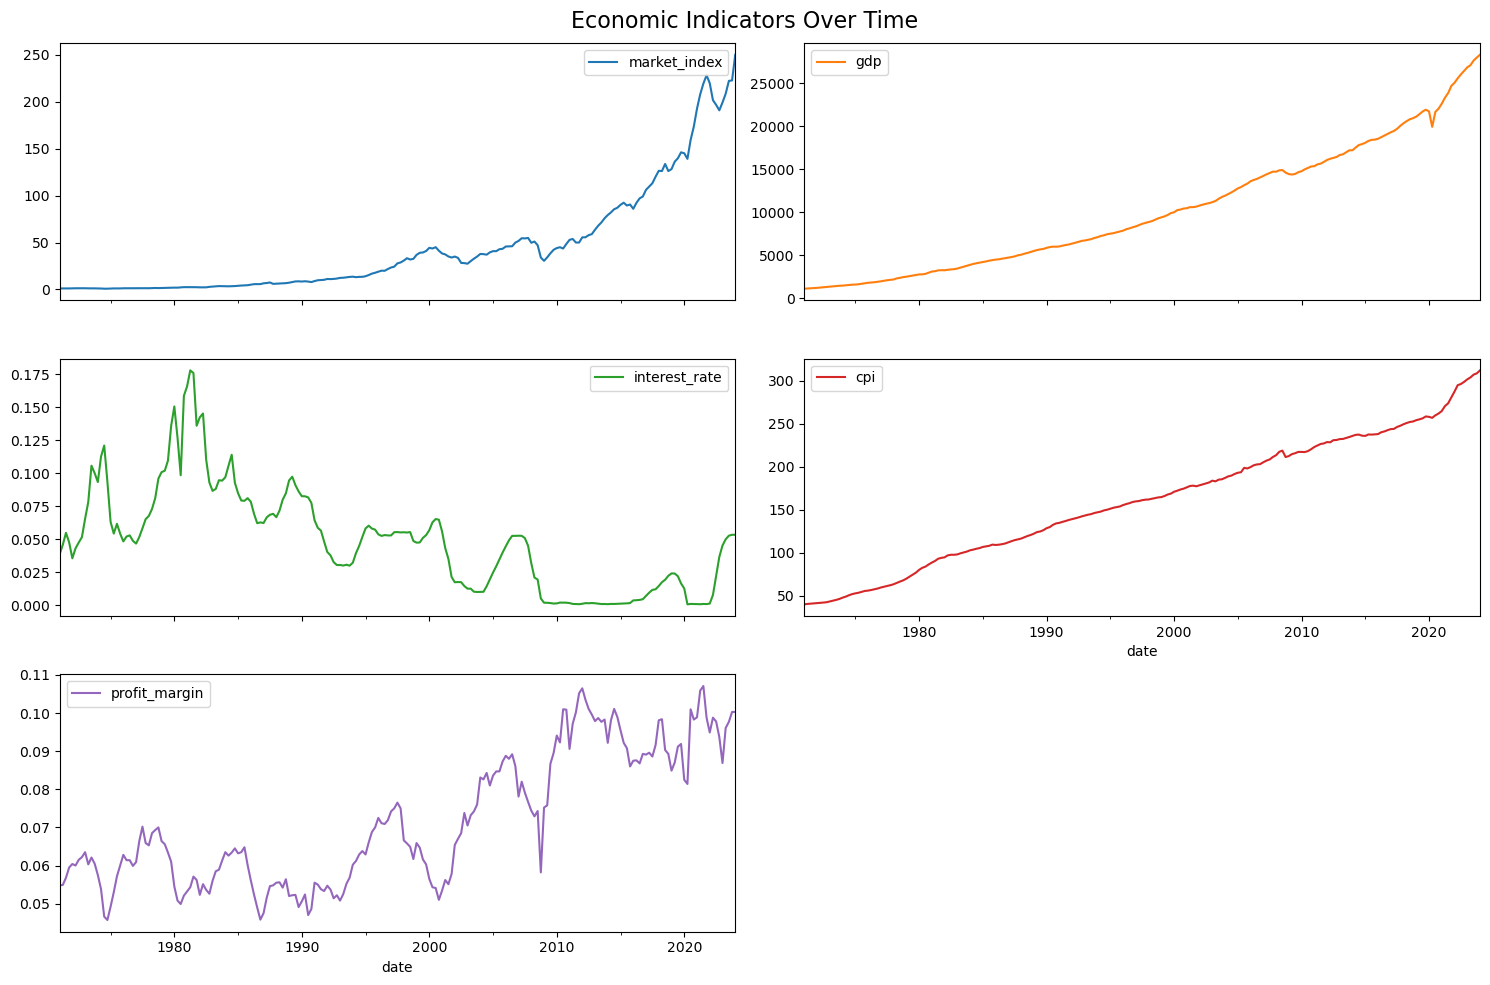

In [43]:
df_updated.plot(y=['market_index', 'gdp', 'interest_rate', 'cpi', 'profit_margin'], subplots=True, layout=(3, 2), figsize=(15, 10))
plt.suptitle('Economic Indicators Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Value')
plt.tight_layout()
plt.show()


### Ordinary Least Square Model (encounters multicollinearity)

In [44]:
x_var_2 = sm.add_constant(df_updated[['gdp','interest_rate','cpi','profit_margin']])
rg2 = sm.OLS(y_var, x_var_2).fit()
print(rg2.summary())

                            OLS Regression Results                            
Dep. Variable:           market_index   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     998.7
Date:                Tue, 07 May 2024   Prob (F-statistic):          1.70e-134
Time:                        21:40:23   Log-Likelihood:                -843.28
No. Observations:                 213   AIC:                             1697.
Df Residuals:                     208   BIC:                             1713.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            50.0683      8.774      5.706

In [45]:
vif_data = x_var_2.drop(columns='const')
vif = pd.DataFrame()
vif["Feature"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
print(vif)

         Feature        VIF
0            gdp  47.996219
1  interest_rate   3.446659
2            cpi  90.355459
3  profit_margin  25.909254


In [46]:
x_var_3 = x_var_2.drop(columns=['cpi'])

It has been observed that there is potential multicollinearity between GDP and CPI, indicated by their notably high Variance Inflation Factors (VIF). Consequently, it has been decided to omit CPI from the analysis to address multicollinearity concerns. This decision is grounded in the recognition that nominal GDP inherently encompasses inflationary effects. 

By solely controlling for nominal GDP, the analysis inherently addresses both the economic development of a nation and its inflationary dynamics. Therefore, by solely utilising nominal GDP, not only resolve the multicollinearity issue but also streamline the models.

In [47]:
rg3 = sm.OLS(y_var, x_var_3).fit()
print(rg3.summary())

                            OLS Regression Results                            
Dep. Variable:           market_index   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     490.9
Date:                Tue, 07 May 2024   Prob (F-statistic):           2.51e-94
Time:                        21:40:23   Log-Likelihood:                -941.34
No. Observations:                 213   AIC:                             1891.
Df Residuals:                     209   BIC:                             1904.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -50.4561     10.585     -4.767

The model's instability persists due to a notably high condition number, resulting in inflated coefficients. Particularly, the independent variable for profit margin exhibits a negatvie relationship with the market index, contradicting prevailing economic beliefs.

In [48]:
x_var_3 = x_var_3.drop(columns='const')
correlation_table = x_var_3.corr()
print(correlation_table)


                    gdp  interest_rate  profit_margin
gdp            1.000000      -0.688833       0.851415
interest_rate -0.688833       1.000000      -0.693673
profit_margin  0.851415      -0.693673       1.000000


In [49]:
vif = pd.DataFrame()
vif["Feature"] = x_var_3.columns
vif["VIF"] = [variance_inflation_factor(x_var_3.values, i) for i in range(x_var_3.shape[1])]
print(vif)

         Feature        VIF
0            gdp  10.382391
1  interest_rate   3.142957
2  profit_margin  15.486578


Potential multicollinearity exists between GDP and profit margin, causing model instability.

### Partial Least Square Regression

Although GDP and profit margin shows high correlation, it's crucial to acknowledge their unique economic significance. To manage potential multicollinearity concerns, the analysis will utilise partial least squares regression, allowing for the simultaneous inclusion of both variables

In [50]:
print(f"dependent variable: {y_var.name}\nindependnet variables: {x_var_3.columns.tolist()}")

dependent variable: market_index
independnet variables: ['gdp', 'interest_rate', 'profit_margin']


In [51]:
n_components_range = range(1, 3)  
X_train, X_val, y_train, y_val = train_test_split(x_var_3, y_var, test_size=0.2, random_state=13)

# Cross validation
cv_scores = []
for n_components in n_components_range:
    pls = PLSRegression(n_components=n_components)
    scores = cross_val_score(pls, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')  # RMSE
    cv_scores.append(np.mean(scores))

best_n_components = n_components_range[np.argmax(cv_scores)]
print("Best n_components:", best_n_components)

Best n_components: 2


In [52]:
pls = PLSRegression(n_components= best_n_components)  
pls.fit(x_var_3, y_var)
latent_variables = [f"lv{i+1}" for i in range(best_n_components)]

print("latent variable equations:")
for i, lv in enumerate(latent_variables):
    print(f"{lv} = ", end="")
    for j, original_var in enumerate(x_var_3.columns.tolist()):
        coefficient = pls.x_loadings_[j, i]
        if coefficient != 0:
            print(f"{coefficient:.4f}*{original_var} + ", end="")
    print("\b\b ")


latent variable equations:
lv1 = 0.6122*gdp + -0.5351*interest_rate + 0.6051*profit_margin  
lv2 = 0.4608*gdp + 0.9344*interest_rate + 0.0876*profit_margin  


In [53]:
x_latent_vars = pls.x_scores_
x_var_4 = pd.DataFrame(x_latent_vars, columns= latent_variables)
x_var_4.index = x_var_3.index
x_var_4 = sm.add_constant(x_var_4)
rg4 = sm.OLS(y_var, x_var_4).fit()
print(rg4.summary())

                            OLS Regression Results                            
Dep. Variable:           market_index   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     601.2
Date:                Tue, 07 May 2024   Prob (F-statistic):           1.21e-87
Time:                        21:40:23   Log-Likelihood:                -960.43
No. Observations:                 213   AIC:                             1927.
Df Residuals:                     210   BIC:                             1937.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.4095      1.517     29.280      0.0

Multicollinearity has been effectively mitigated by employing partial least squares regression analysis. Also noteworthy is that the R-squared value has improved when compared to the simple regression model.

In [54]:
num_iterations = 1000
num_latent_variables = 2
boot_loadings = np.zeros((num_iterations, len(x_var_3.columns.tolist()), num_latent_variables))

for i in range(num_iterations):
    bootstrap_indices = np.random.choice(len(x_var_3), size=len(x_var_3), replace=True)
    pls.fit(x_var_3.iloc[bootstrap_indices], y_var.iloc[bootstrap_indices])
    boot_loadings[i, :, :] = pls.x_loadings_ # 2 latent variables

# 95% confidence interval
lower_bound = np.percentile(boot_loadings, 2.5, axis=0)
upper_bound = np.percentile(boot_loadings, 97.5, axis=0)

for j in range(num_latent_variables):
    print(f"Latent Variable {j+1}:")
    for i, original_var in enumerate(x_var_3.columns.tolist()):
        lower_bound_val = lower_bound[i, j]
        upper_bound_val = upper_bound[i, j]
        print(f"{original_var}: Lower Bound = {lower_bound_val:.4f}, Upper Bound = {upper_bound_val:.4f} ", end="")
        if lower_bound_val > 0 or upper_bound_val < 0:
            print(f'"statistically significant"')
        else:
            print(f'"not statistically significant"')
    print()



Latent Variable 1:
gdp: Lower Bound = 0.6027, Upper Bound = 0.6236 "statistically significant"
interest_rate: Lower Bound = -0.5515, Upper Bound = -0.5153 "statistically significant"
profit_margin: Lower Bound = 0.5920, Upper Bound = 0.6181 "statistically significant"

Latent Variable 2:
gdp: Lower Bound = 0.3863, Upper Bound = 0.5540 "statistically significant"
interest_rate: Lower Bound = 0.8803, Upper Bound = 0.9657 "statistically significant"
profit_margin: Lower Bound = -0.0203, Upper Bound = 0.1827 "not statistically significant"



Although the profit margin associated with the second latent variable does not demonstrate statistical significance at the 5% level, it is noteworthy that its lower bound is marginally below the established zero threshold. More importantly, all other variables within the model exhibit statistical significance.

Text(0.5, 1.0, 'Market Framework vs Market Index')

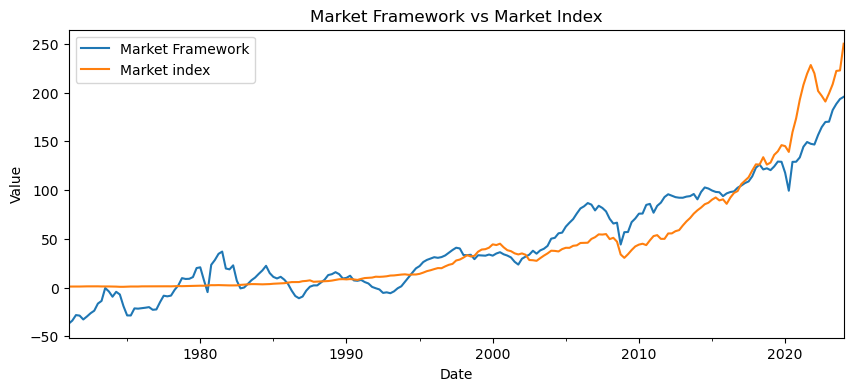

In [55]:
plt.figure(figsize=(10,4))
market_framework = rg4.predict(x_var_4)
market_framework.plot(legend = True)
df_updated['market_index'].plot(legend = True)
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(labels=['Market Framework', 'Market index'])
plt.title('Market Framework vs Market Index')

 <center><h1 style="font-size:3rem;color:purple;">Market Sentiment</h1></center>

The objective of this analysis is to identify the market sentiment by controlling for interest rates and profit margins in relation to the market cap to GDP. By examining the interplay between these factors, the study aims to pinpoint influential drivers behind shifts in market sentiment. Through this investigation, the goal is to provide valuable insights into the dynamics of investor confidence, aiding in the identification of key turning points in the market and facilitating more informed decision-making for stakeholders.

The Market Cap to GDP Ratio, also known as the "Buffett Indicator" is a metric used to gauge whether the stock market is overvalued or undervalued relative to the size of the economy. It's named after Warren Buffett, who popularised its use as a valuation tool. The calculation involves dividing the total market capitalisation of all publicly traded stocks by the Gross Domestic Product (GDP) of a country. 

However, contemporary critiques suggest that while the Buffett Indicator offers valuable historical context, its relevance has diminished over time. One notable limitation is its lack to account for evolving business dynamics, including the impact of borrowing costs and technological advancements on corporate profitability. As such, while the indicator remains a useful benchmark, it is increasingly viewed as insufficient in capturing the modern economic landscapes.

In [56]:
df_updated['market-gdp'] = df_updated['market_index'] / df_updated['gdp']
df_updated_bi = df_updated[['market-gdp','interest_rate','profit_margin']]

Text(0.5, 0, 'Date')

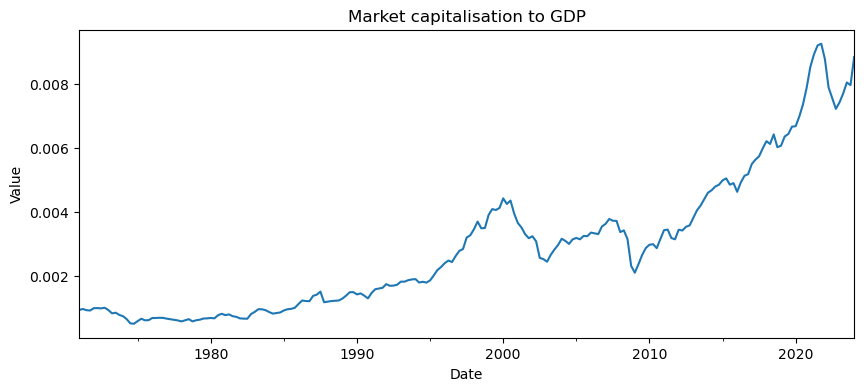

In [57]:
df_updated_bi['market-gdp'].plot(figsize=(10,4))
plt.title('Market capitalisation to GDP')
plt.ylabel('Value')
plt.xlabel('Date')

Please note that the ratio may not conform to commonly known figures due to the lack of normalisation in the values. Nonetheless, the data remain sufficiently accurate to facilitate statistical analysis.

In [58]:
y_var_bi = df_updated_bi['market-gdp']
x_var_5 = df_updated_bi[['interest_rate', 'profit_margin']]

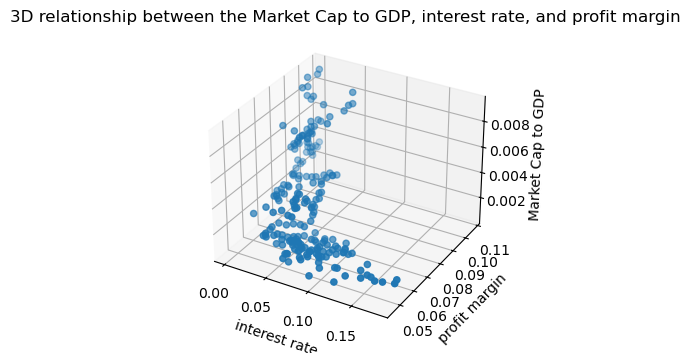

In [59]:
explanatory_variables = np.array(x_var_5)
dependent_variable = np.array(y_var_bi)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('interest rate')
ax.set_ylabel('profit margin')
ax.set_zlabel('Market Cap to GDP')
plt.title('3D relationship between the Market Cap to GDP, interest rate, and profit margin')
ax.scatter(explanatory_variables[:, 0], explanatory_variables[:, 1], dependent_variable)

In [60]:
x_var_5 = sm.add_constant(x_var_5)
rg5 = sm.OLS(y_var_bi, x_var_5).fit()
print(rg5.summary())

                            OLS Regression Results                            
Dep. Variable:             market-gdp   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     159.0
Date:                Tue, 07 May 2024   Prob (F-statistic):           8.88e-43
Time:                        21:40:24   Log-Likelihood:                 1102.3
No. Observations:                 213   AIC:                            -2199.
Df Residuals:                     210   BIC:                            -2189.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0025      0.001     -3.744

The regression model demonstrates stability, with both dependent variables exhibiting significance. The coefficients reveal a negative correlation between the interest rate and market capitalisation to GDP ratio, while indicating a positive correlation between profit margin and market capitalisation to GDP ratio. These findings align with established economic beliefs.

Text(0.5, 1.0, 'Market Sentiment vs Market Index')

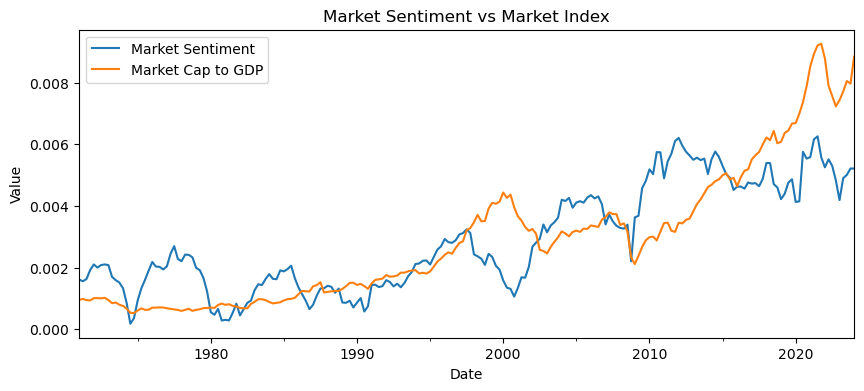

In [61]:
plt.figure(figsize=(10,4))
market_sentiment = rg5.predict(x_var_5)
market_sentiment.plot(legend = True)
df_updated_bi['market-gdp'].plot(legend = True)
plt.ylabel('Value')
plt.xlabel('Date')
plt.legend(labels=['Market Sentiment', 'Market Cap to GDP'])
plt.title('Market Sentiment vs Market Index')

 <center><h3 style="font-size:2rem;color:#FF8C00;"> Market Analysis Summary</h3></center>

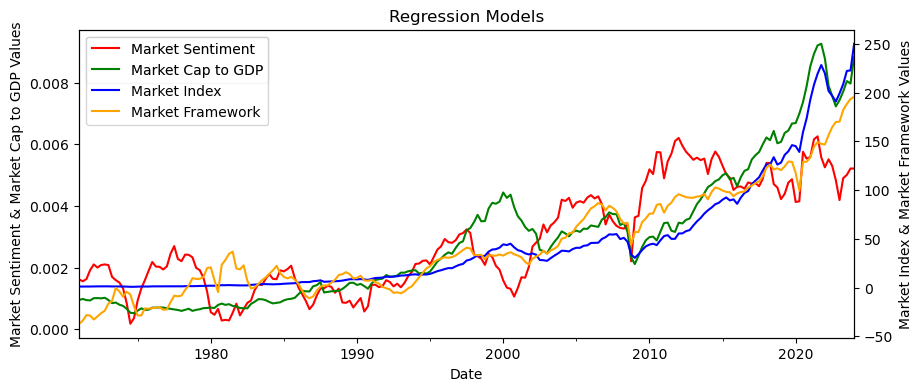

In [62]:
market_sentiment = rg5.predict(x_var_5)
market_sentiment_mean = np.mean(market_sentiment)
market_sentiment_std = np.std(market_sentiment)

fig, ax1 = plt.subplots(figsize=(10, 4))
market_sentiment.plot(legend=True, label='Market Sentiment', ax=ax1, color='red')
y_var_bi.plot(legend=True, label='Market Cap to GDP', ax=ax1, color='green')

ax1.set_ylabel('Market Sentiment & Market Cap to GDP Values')
ax1.set_xlabel('Date')
ax1.set_title('Regression Models')

ax2 = ax1.twinx()
ax2.set_ylabel('Market Index & Market Framework Values')
df_updated['market_index'].plot(legend=True, label='Market Index', ax=ax2, color='blue')
market_framework.plot(legend = True, label='Market Framework', color='orange')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

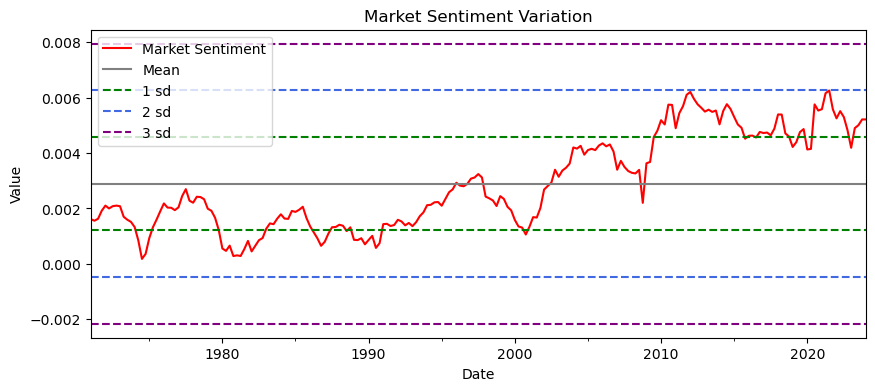

In [63]:
market_sentiment = rg5.predict(x_var_5)
market_sentiment_mean = np.mean(market_sentiment)
market_sentiment_std = np.std(market_sentiment)

plt.figure(figsize=(10, 4))
market_sentiment.plot(legend=True, label='Market Sentiment', color='red')
plt.axhline(market_sentiment_mean, color='grey', linestyle='-', label='Mean')
plt.axhline(market_sentiment_mean + market_sentiment_std, color='g', linestyle='--', label='1 sd')
plt.axhline(market_sentiment_mean - market_sentiment_std, color='g', linestyle='--')
plt.axhline(market_sentiment_mean + 2*market_sentiment_std, color='royalblue', linestyle='--', label='2 sd')
plt.axhline(market_sentiment_mean - 2*market_sentiment_std, color='royalblue', linestyle='--')
plt.axhline(market_sentiment_mean + 3*market_sentiment_std, color='purple', linestyle='--', label='3 sd')
plt.axhline(market_sentiment_mean - 3*market_sentiment_std, color='purple', linestyle='--')
plt.ylabel('Value')
plt.xlabel('Date')
plt.title('Market Sentiment Variation')
plt.legend()
plt.show()


The standard deviation from the mean within the Market Sentiment model serves as a potential metric for identifying notable shifts in investor sentiment toward the market. Instances where values significantly diverge from the mean signal potential extremes in market perception, indicating conditions that may be characterised as either excessively bullish ("hot") or overly bearish ("cold"). 

These deviations provide insight into the degree of divergence from typical expectations, thereby facilitating the recognition of significant shifts in market sentiment.

 <center><h1 style="font-size:3rem;color:#008080;">Model Equations</h1></center>

$$ \text{Market Sentiment} = -0.0025 -0.0093 \times \text{interest rate} + 0.0821 \times \text{profit margin} $$
$$ \text{Market Index Analysis} = 44.4095 + 37.07265 \times \text{gdp} + 18.30313 \times \text{interest rate} + 21.99363 \times \text{profit margin} $$